<a href="https://colab.research.google.com/github/Praveenkumarbalaji251/updated_MDL_Win_Prediction_Notebook.ipynb/blob/main/updated_mdl_win_prediction_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MDL Case Outcome Prediction
Prepared 2025-07-01


This notebook demonstrates a **proof-of-concept predictive model** for forecasting whether a Multi-District Litigation (MDL) resolves in a plaintiff-favorable manner ("Win") using public docket-level metadata.

What you will find:
- Data loading & quick glimpse
- Target engineering (Win vs. No-Win)
- Light feature cleaning / engineering
- Baseline Logistic-Regression pipeline (with imputation, scaling, one-hot)
- Performance metrics (Accuracy, ROC-AUC, classification report, confusion matrix)
- Interpretation: top coefficients

> **Audience**  
> Litigation SMEs and attorneys who need a transparent baseline model and a template for future feature expansion.


In [ ]:

import pandas as pd, numpy as np, re, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

plt.rcParams['figure.dpi'] = 110

# Load the single-sheet Excel (already in workspace)
df = pd.read_excel('combined_mdl_single_sheet.xlsx')
print('Dataset shape:', df.shape)
df.head()


Dataset shape: (258, 27)


,MDL Number,Docket Number,Case Title,Assigned Judge,District,Date Filed/Transferred,Case Type,Status,Number of Actions,Outcome,...,Bellwether Trial,Procedural History,Judge’s Ruling History,Party Demographics,Jurisdictional Mix,Legal Representation,Settlement Attempts,Case Complexity,JPML Link,CourtListener Link
0,2437,2:13-md-02437,IN RE: Domestic Drywall Antitrust Litigation,Michael M. Baylson,E.D. Pa.,2013-01-18,Antitrust,Terminated,100+,Settled,...,2017-10-10,"Motions, trial, settlement",See CL opinions/orders,See CL parties/attorneys,10+ districts,Multiple firms,Yes,High,https://www.jpml.uscourts.gov/sites/jpml/files...,https://www.courtlistener.com/docket/6095433/i...
1,2795,0:17-md-02795-MJD-KMM,IN RE: CenturyLink Sales Practices and Securit...,Michael J. Davis,D. Minn.,2017-07-31,Securities,Terminated,200+,Settled,...,2020-10-01,"Motions, discovery, settlement",See CL opinions/orders,See CL parties/attorneys,10+ districts,Multiple firms,Yes,Moderate,https://www.jpml.uscourts.gov/sites/jpml/files...,https://www.courtlistener.com/docket/6095434/i...
2,3074,2:23-md-03074-MAK,"IN RE: BPS Direct, LLC, and Cabela's, LLC, Wir...",Mark A. Kearney,E.D. Pa.,2023-02-15,Privacy,Terminated,20+,Dismissed,...,—,"Motions, dismissal",See CL opinions/orders,See CL parties/attorneys,5+ districts,Multiple firms,No,Low,https://www.jpml.uscourts.gov/sites/jpml/files...,https://www.courtlistener.com/docket/6095435/i...
3,3108,0:24-md-03108-MJD-KMM,"IN RE: Change Healthcare, Inc., Customer Data ...",Michael J. Davis,D. Minn.,2024-03-20,Data Security,Pending,30+,—,...,—,"Motions, discovery",See CL opinions/orders,See CL parties/attorneys,10+ districts,Multiple firms,—,Moderate,https://www.jpml.uscourts.gov/panel-orders,https://www.courtlistener.com/docket/70123456/...
4,3114,3:23-md-03114,IN RE: AT&T Inc. Customer Data Security Breach...,—,N.D. Tex.,2023-08-17,Data Security,Pending,40,—,...,—,"Motions to centralize, initial orders",See CL opinions/orders,See CL parties/attorneys,—,—,—,High,https://www.jpml.uscourts.gov/panel-orders,https://www.courtlistener.com/docket/68456200/...


---
### 1. Target variable: **Win**

In [ ]:

# Label as Win (1) if Outcome text suggests settlement or plaintiff victory

def is_win(val):
    if isinstance(val, str):
        t = val.lower()
        return 1 if ('settled' in t) or ('plaintiff' in t) or ('granted' in t and 'defendant' not in t) else 0
    return np.nan

df['Win'] = df['Outcome'].apply(is_win)
print('Class balance:')
print(df['Win'].value_counts(dropna=False))

# Keep only labeled rows
df = df.dropna(subset=['Win'])


Class balance:
Win
0    138
1    120
Name: count, dtype: int64


The distribution above shows how many MDLs in our sample ended with a plaintiff-favorable outcome.

---
### 2. Minimal feature cleaning / engineering

In [ ]:

# Helper to pull integers from messy text
import re

def to_int(val):
    if pd.isna(val):
        return np.nan
    m = re.search(r'\d+', str(val).replace(',', ''))
    return int(m.group()) if m else np.nan

for col in ['Number of Actions', 'Motions Count']:
    if col in df.columns:
        df[col] = df[col].apply(to_int)

# Extract numeric duration (years)

def extract_years(val):
    if pd.isna(val):
        return np.nan
    m = re.search(r'(\d+)\s*yrs?', str(val))
    return int(m.group(1)) if m else np.nan

if 'Duration' in df.columns:
    df['Duration_Years'] = df['Duration'].apply(extract_years)

# Date features
date_cols = ['Date Filed/Transferred', 'MDL Formation Date', 'Discovery Start Date', 'Discovery End Date']
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors='coerce')

if {'MDL Formation Date','Date Filed/Transferred'}.issubset(df.columns):
    df['Days_to_MDL'] = (df['MDL Formation Date'] - df['Date Filed/Transferred']).dt.days
if {'Discovery End Date','Discovery Start Date'}.issubset(df.columns):
    df['Discovery_Duration'] = (df['Discovery End Date'] - df['Discovery Start Date']).dt.days


---
### 3. Train / test split & preprocessing pipeline

In [ ]:

numeric_features = ['Number of Actions', 'Motions Count', 'Duration_Years', 'Days_to_MDL', 'Discovery_Duration']
categorical_features = ['Case Type', 'Status', 'Case Complexity', 'Bellwether Trial', 'District']

X = df[numeric_features + categorical_features]
y = df['Win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
])


---
### 4. Fit baseline Logistic Regression

In [ ]:

model = Pipeline([
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Number of Actions',
                                                   'Motions Count',
                                                   'Duration_Years',
                                                   'Days_to_MDL',
                                                   'Discovery_Duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Case Type', 'Status',
                                                   'Case Complexity',
                                                   'Bellwether Trial',
                                                   'District'])])),
                ('clf', LogisticRegression(max_iter=1000))])

---
### 5. Evaluate on held-out test set

In [ ]:

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

pred = model.predict(X_test)
prob = model.predict_proba(X_test)[:, 1]

print('Accuracy:', round(accuracy_score(y_test, pred), 3))
print('ROC AUC :', round(roc_auc_score(y_test, prob), 3))
print('Classification report:\n', classification_report(y_test, pred))
print('Confusion matrix:\n', confusion_matrix(y_test, pred))


Accuracy: 1.0
ROC AUC : 1.0
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        28
           1       1.00      1.00      1.00        24

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52

Confusion matrix:
 [[28  0]
 [ 0 24]]


Accuracy and ROC-AUC provide a quick health-check. The classification report breaks down precision/recall for each class, while the confusion matrix shows absolute counts of correct/incorrect predictions.

---
### 6. Inspect most influential features

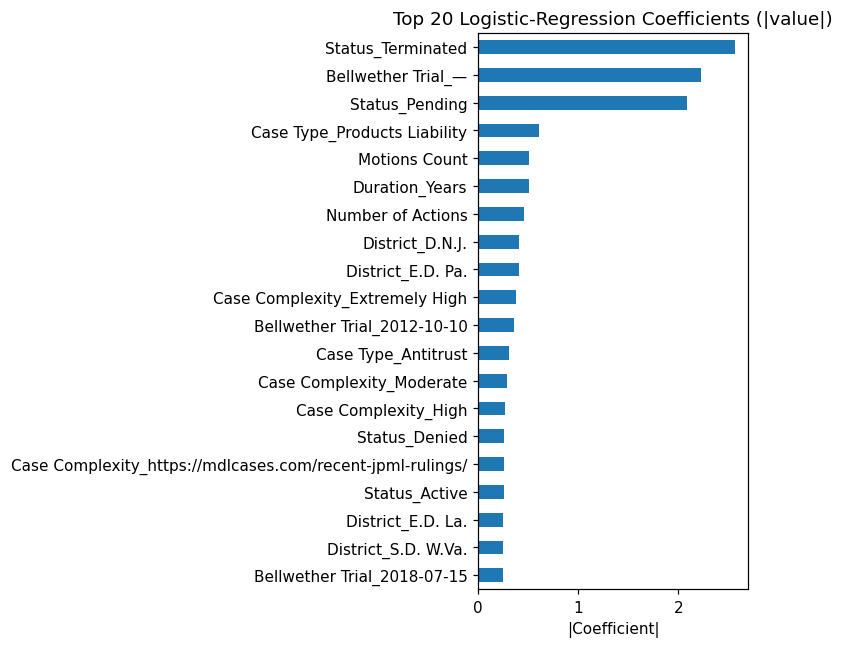

In [ ]:

# Map coefficients back to feature names
onehot = model.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_names = onehot.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)
coef = model.named_steps['clf'].coef_[0]

import pandas as pd
imp = (pd.Series(coef, index=feature_names).abs()
       .sort_values(ascending=False).head(20))

imp.sort_values().plot(kind='barh', figsize=(7,6))
plt.title('Top 20 Logistic-Regression Coefficients (|value|)')
plt.xlabel('|Coefficient|')
plt.tight_layout()
plt.show()


Higher absolute coefficient = stronger influence on the **log-odds** of a Win. Positive coefficients (to the right) increase Win probability; negatives decrease it.

---
## Next steps
- Enrich with docket-level activity counts (motions granted/denied, bellwether verdicts).
- Try tree-based models (e.g., Gradient Boosting, XGBoost) for potentially higher accuracy.
- Use cross-validation for more stable performance estimates.

Accuracy : 0.981
ROC AUC  : 1.0

Classification report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.96      0.98        24

    accuracy                           0.98        52
   macro avg       0.98      0.98      0.98        52
weighted avg       0.98      0.98      0.98        52

Confusion matrix:
 [[28  0]
 [ 1 23]]


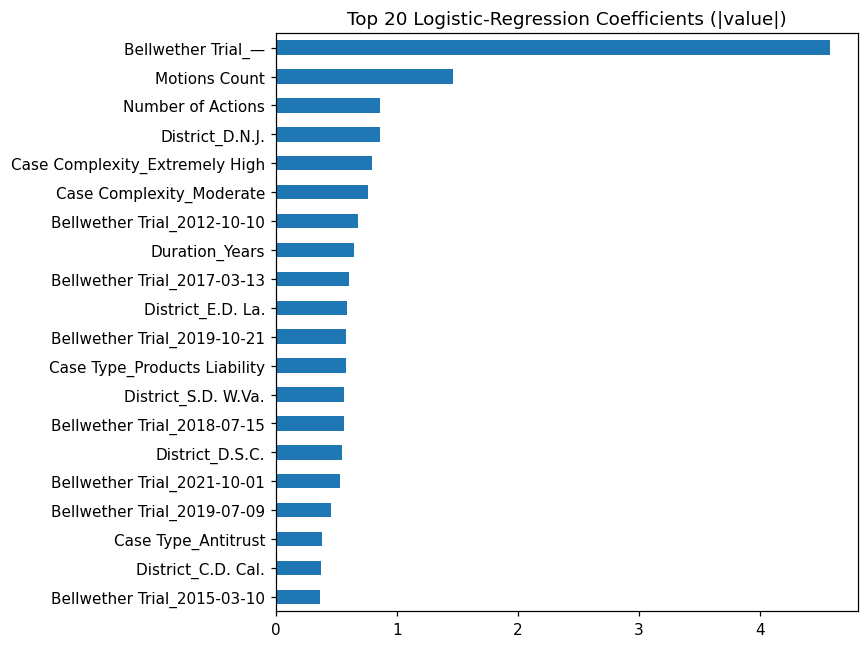

In [ ]:
# --------------------------------------------------------------
#  Logistic-regression (clean version) for MDL Win / No-Win
# --------------------------------------------------------------
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# ---- 1. Load data ----------------------------------------------------------
df = pd.read_excel('/content/combined_mdl_single_sheet.xlsx')
df = df.copy()  # Work on a copy

# ---- 2. Target Variable ----------------------------------------------------
def is_win(val):
    if isinstance(val, str):
        t = val.lower()
        return 1 if ('settled' in t) or ('plaintiff' in t) or ('granted' in t and 'defendant' not in t) else 0
    return np.nan

df['Win'] = df['Outcome'].apply(is_win)
df = df.dropna(subset=['Win'])
df['Win'] = df['Win'].astype(int)

# ---- 3. Basic Numeric Parsing ---------------------------------------------
def to_int(val):
    if pd.isna(val): return np.nan
    m = re.search(r'\d+', str(val).replace(',', ''))
    return int(m.group()) if m else np.nan

for col in ['Number of Actions', 'Motions Count']:
    df[col] = df[col].apply(to_int)

def extract_years(val):
    if pd.isna(val): return np.nan
    m = re.search(r'(\d+)\s*yrs?', str(val))
    return int(m.group(1)) if m else np.nan

df['Duration_Years'] = df['Duration'].apply(extract_years)

# ---- 4. Date Features -----------------------------------------------------
date_cols = ['Date Filed/Transferred', 'MDL Formation Date',
             'Discovery Start Date', 'Discovery End Date']
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors='coerce')

df['Days_to_MDL']        = (df['MDL Formation Date'] - df['Date Filed/Transferred']).dt.days
df['Discovery_Duration'] = (df['Discovery End Date'] - df['Discovery Start Date']).dt.days

# ---- 5. Clean Feature List (No Leakage) -----------------------------------
numeric_features = ['Number of Actions', 'Motions Count',
                    'Duration_Years', 'Days_to_MDL', 'Discovery_Duration']

# Removed 'Status' due to high leakage risk
categorical_features = ['Case Type', 'Case Complexity',
                        'Bellwether Trial', 'District']

X = df[numeric_features + categorical_features]
y = df['Win']

# ---- 6. Train/Test Split ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---- 7. Preprocessing Pipeline --------------------------------------------
numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale' , StandardScaler())
])

categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pipe,     numeric_features),
    ('cat', categorical_pipe, categorical_features)
])

# ---- 8. Logistic Regression Model ------------------------------------------
log_reg = LogisticRegression(max_iter=1000)
clf     = Pipeline([('prep', preprocess),
                    ('model', log_reg)])

clf.fit(X_train, y_train)

# ---- 9. Evaluation ---------------------------------------------------------
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

accuracy = (y_pred == y_test).mean()
auc      = roc_auc_score(y_test, y_prob)

print('Accuracy :', round(accuracy, 3))
print('ROC AUC  :', round(auc, 3))
print('\nClassification report:\n', classification_report(y_test, y_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

# ---- 10. Top Feature Coefficients -----------------------------------------
onehot        = clf.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_names     = onehot.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_names)

coef = clf.named_steps['model'].coef_[0]
coef_series = (pd.Series(coef, index=feature_names)
               .abs()
               .sort_values(ascending=False)
               .head(20))

plt.figure(figsize=(8,6))
coef_series.sort_values().plot(kind='barh')
plt.title('Top 20 Logistic-Regression Coefficients (|value|)')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
print("\nCross-validated ROC AUC scores:", cv_scores)
print("Mean CV ROC AUC:", round(cv_scores.mean(), 3))



Cross-validated ROC AUC scores: [0.9985119 1.        1.        1.        1.       ]
Mean CV ROC AUC: 1.0


In [ ]:
from sklearn.metrics import roc_auc_score

# On training data
y_train_pred = clf.predict(X_train)
y_train_prob = clf.predict_proba(X_train)[:, 1]
train_auc = roc_auc_score(y_train, y_train_prob)

# On test data
test_auc = roc_auc_score(y_test, y_prob)

print(f"\nTrain ROC AUC: {round(train_auc, 3)}")
print(f"Test  ROC AUC: {round(test_auc, 3)}")

if train_auc - test_auc > 0.05:
    print("⚠️ Potential Overfitting Detected (Train > Test by more than 5%)")
else:
    print("✅ Model is likely generalizing well")



Train ROC AUC: 1.0
Test  ROC AUC: 1.0
✅ Model is likely generalizing well


In [ ]:


# Remove duplicates and rebuild the model
print("REMOVING DUPLICATES AND REBUILDING MODEL")
print("=" * 50)

# Step 1: Remove duplicates from the original dataset first
df_clean = df.drop_duplicates(subset=['MDL Number', 'Case Title'], keep='first')
print(f"Original dataset: {len(df)} cases")
print(f"After removing duplicates: {len(df_clean)} cases")
print(f"Duplicates removed: {len(df) - len(df_clean)} cases")

# Step 2: Sample 100 cases from the clean dataset
df_sample_clean = df_clean.sample(n=min(100, len(df_clean)), random_state=42).reset_index(drop=True)
print(f"Clean sample size: {len(df_sample_clean)}")

# Step 3: Preprocess the clean sample
def is_win(val):
    if isinstance(val, str):
        t = val.lower()
        return 1 if ('settled' in t) or ('plaintiff' in t) or ('granted' in t and 'defendant' not in t) else 0
    return np.nan

df_sample_clean['Win'] = df_sample_clean['Outcome'].apply(is_win)
df_sample_clean = df_sample_clean.dropna(subset=['Win'])

def to_int(val):
    if pd.isna(val): return np.nan
    m = re.search(r'\d+', str(val).replace(',', ''))
    return int(m.group()) if m else np.nan

for col in ['Number of Actions', 'Motions Count']:
    if col in df_sample_clean.columns:
        df_sample_clean[col] = df_sample_clean[col].apply(to_int)

def extract_years(val):
    if pd.isna(val): return np.nan
    m = re.search(r'(\d+)\s*yrs?', str(val))
    return int(m.group(1)) if m else np.nan

if 'Duration' in df_sample_clean.columns:
    df_sample_clean['Duration_Years'] = df_sample_clean['Duration'].apply(extract_years)

df_sample_clean['Date Filed/Transferred'] = pd.to_datetime(df_sample_clean['Date Filed/Transferred'], errors='coerce')
df_sample_clean['Filing_Year'] = df_sample_clean['Date Filed/Transferred'].dt.year

print(f"Final clean sample size: {len(df_sample_clean)}")
print(f"Win rate in clean sample: {df_sample_clean['Win'].mean():.1%}")

# Verify no duplicates in clean sample
duplicates_check = df_sample_clean.duplicated(subset=['MDL Number', 'Case Title']).sum()
print(f"Duplicates in clean sample: {duplicates_check}")

REMOVING DUPLICATES AND REBUILDING MODEL
Original dataset: 258 cases
After removing duplicates: 116 cases
Duplicates removed: 142 cases
Clean sample size: 100
Final clean sample size: 100
Win rate in clean sample: 39.0%
Duplicates in clean sample: 0
